# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import statsmodels.api as sm
import json
import sys
import requests
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
with open('data/full_data.pkl','rb') as f:
    df = pkl.load(f)

# Select the features and target for our modeling

In [3]:
features = ['bronx','brooklyn', 'manhattan', 'queens', 'direction_bronx', 'direction_brooklyn', 'direction_manhattan',
            'direction_queens', 'direction_both', 'direction_north', 'direction_south', 'passenger_disruption',
            'station_integrity_disruption', 'mechanical_and_track_disruption', 'train_disruption', 'weather_disruption',
            'signal_disruption', 'switch_disruption', 'mon', 'tue', 'wed', 'th', 'fri', 'weekend','holiday','rush_hour', 
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'fastest_wind_spd','major_conditions',
             'minor_conditions', 'neutral_conditions', 'clear_conditions', 'prcp', 'snowfall', 'snowfall_depth',]

In [4]:
df.insert(0,'delayed_all',0)

In [5]:
ind_both = df.loc[(df['delayed_div_a']==1)&(df['delayed_div_b']==1)].index
ind_a = df.loc[(df['delayed_div_a']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index
ind_b = df.loc[(df['delayed_div_b']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index

In [6]:
df.loc[ind_a,'delayed_all'] = 0
df.loc[ind_b,'delayed_all'] = 1
df.loc[ind_both,'delayed_all'] = 2
df['delayed_all'].value_counts()

1    47389
0    32213
2      105
Name: delayed_all, dtype: int64

# Building a Model for all using clustering

## KNN Classification

In [7]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

0.6023485722888543


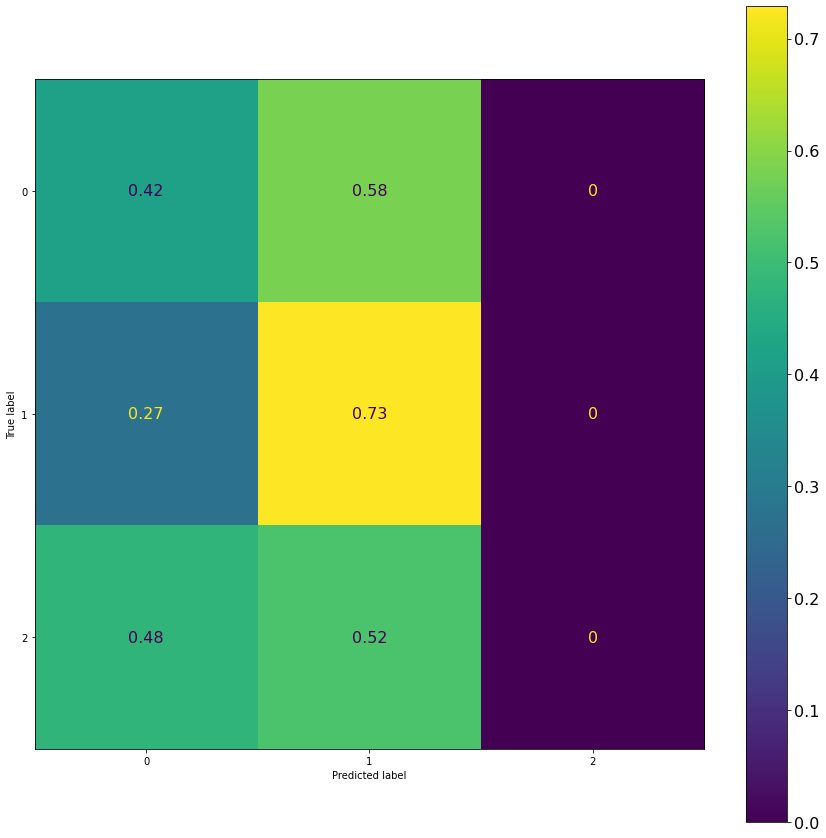

In [8]:
# test
knn = KNeighborsClassifier()
model = knn.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(model,X_test,y_test,normalize='true',ax=ax)
plt.show()

Pipeline(steps=[('knn',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      weights='distance'))])


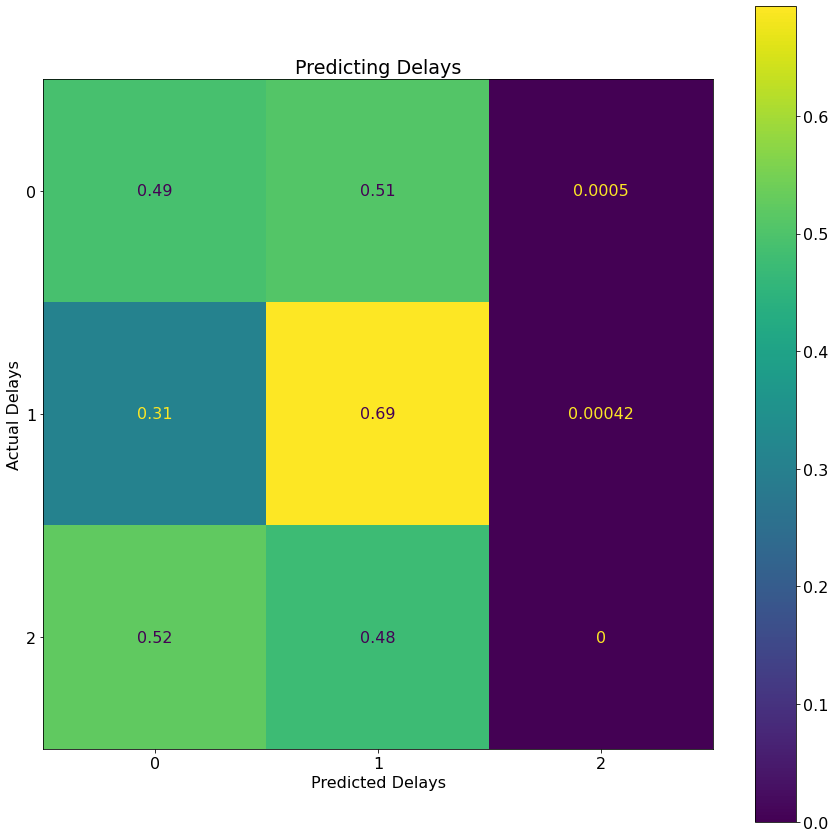

In [9]:
knn_params = {'knn__n_neighbors':[3,5,7],
             'knn__weights':['uniform','distance'],
             'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
             'knn__metric':['minkowski','euclidean','manhattan']}
pipe_knn = Pipeline(steps=[('knn',KNeighborsClassifier())])

gsv_knn = GridSearchCV(pipe_knn,knn_params,scoring='homogeneity_score')

gsv_knn.fit(X_train,y_train)

y_pred = gsv_knn.best_estimator_.predict(X_test)

print(gsv_knn.best_estimator_)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gsv_knn,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

In [10]:
print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%
""")


Overall Accuracy: 61.1%,
F1 Score: 61.1%



## KMeans Clustering

In [11]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
kmeans_params = {'km__n_clusters':[3],
                 'km__algorithm':['auto','full','elkan']}
pipe_km = Pipeline(steps=[('km',KMeans())])

gsv_km = GridSearchCV(pipe_km,kmeans_params,scoring='homogeneity_score')

gsv_km.fit(X_train, y_train)

y_pred = gsv_km.best_estimator_.predict(X_test)

print(gsv_km.best_estimator_)

Pipeline(steps=[('km', KMeans(algorithm='elkan', n_clusters=3))])


In [17]:
gsv_km

GridSearchCV(estimator=Pipeline(steps=[('km', KMeans())]),
             param_grid={'km__algorithm': ['auto', 'full', 'elkan'],
                         'km__n_clusters': [3]},
             scoring='homogeneity_score')

## Div A Trains

In [15]:
X = df[features]
y = df['delayed_div_a']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

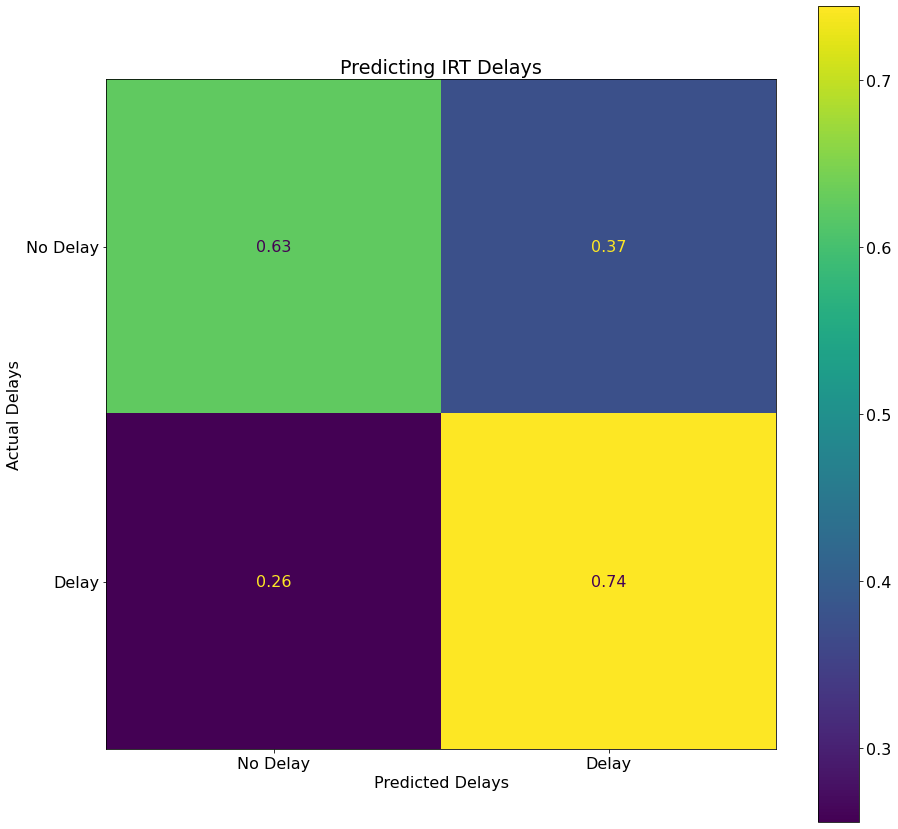

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])

Overall Accuracy: 68.92%,
F1 Score: 63.28%

Overall SMOTE Accuracy: 67.36%,
SMOTE F1 Score: 64.85%


In [16]:
bnb_params = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe_bnb = Pipeline(steps=[('bnb',BernoulliNB())])

gsv_bnb = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')
gsv_bnb_sm = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')

gsv_bnb.fit(X_train, y_train)
gsv_bnb_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_bnb.best_estimator_.predict(X_test)
y_pred_sm = gsv_bnb_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_bnb_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")